In [1]:
#@title 0. 설정
HF_IMAGES_V3 = "pomupomu2/test_hbr_images_v3"
HF_META_V3   = "pomupomu2/test_hbr_meta_v3"
HF_PRIVATE   = True

QUERY_TAGS = "heaven_burns_red"

WORK_DIR = "/content/dl_work_v3"
SLEEP_SEC = 0.8
RETRIES = 10
ABORT_SKIPS = 200

UPDATED_RESCAN_PAGES = 1   # order:updated 상위 N페이지 재스캔
MAIN_RANGE_PAGES = 50      # 기본 tags 수집 페이지 범위 (페이지당 100)

# v3 zip 샤딩
ZIP_TARGET_FILES = 500     # zip 하나에 넣을 이미지 개수(권장 200~1000)
ZIP_NAME_PREFIX = "updates"  # "base" / "updates" 등

print("Config loaded")
print("images_v3:", HF_IMAGES_V3)
print("meta_v3  :", HF_META_V3)
print("tags     :", QUERY_TAGS)


Config loaded
images_v3: pomupomu2/test_hbr_images_v3
meta_v3  : pomupomu2/test_hbr_meta_v3
tags     : heaven_burns_red


In [1]:
#@title 1. 설치
!pip -q install -U "requests==2.32.4" "huggingface-hub==0.34.4" "datasets>=2.20.0" "gallery-dl>=1.28.0" "pyarrow>=14.0.0" "tqdm"
!pip -q install -U hf_transfer || true


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 808.9/808.9 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 13.2 MB/s eta 0:00:00


In [3]:
#@title 2. HF 준비 + state/archive 내려받기
import os, json, time, shutil
from huggingface_hub import HfApi, create_repo, hf_hub_download
from google.colab import userdata

hf_token = userdata.get("HF_KEY")
if not hf_token:
    raise RuntimeError("HF_KEY 토큰을 찾지 못했습니다.")

api = HfApi(token=hf_token)

create_repo(HF_IMAGES_V3, repo_type="dataset", private=HF_PRIVATE, exist_ok=True, token=hf_token)
create_repo(HF_META_V3,   repo_type="dataset", private=HF_PRIVATE, exist_ok=True, token=hf_token)

os.makedirs(WORK_DIR, exist_ok=True)
STATE_DIR = os.path.join(WORK_DIR, "state")
os.makedirs(STATE_DIR, exist_ok=True)

ARCHIVE_LOCAL = os.path.join(STATE_DIR, "archive.sqlite3")
STATE_LOCAL   = os.path.join(STATE_DIR, "state.json")

def download_if_exists(repo_id, path_in_repo, out_path):
    try:
        p = hf_hub_download(repo_id, repo_type="dataset", filename=path_in_repo, token=hf_token)
        shutil.copy(p, out_path)
        return True
    except Exception:
        return False

# archive/state는 images_v3에만 둠
if download_if_exists(HF_IMAGES_V3, "state/archive.sqlite3", ARCHIVE_LOCAL):
    print("✅ loaded archive.sqlite3 from HF")
else:
    print("ℹ️ no archive.sqlite3 on HF (first run).")

if download_if_exists(HF_IMAGES_V3, "state/state.json", STATE_LOCAL):
    print("✅ loaded state.json from HF")
    print(open(STATE_LOCAL, "r", encoding="utf-8").read())
else:
    print("ℹ️ no state.json on HF (first run).")

print("ARCHIVE_LOCAL:", ARCHIVE_LOCAL)


ℹ️ no archive.sqlite3 on HF (first run).
ℹ️ no state.json on HF (first run).
ARCHIVE_LOCAL: /content/dl_work_v3/state/archive.sqlite3


In [6]:
#@title 3. Danbooru 수집 (gallery-dl) - UPDATED만 (증분용)
import os, subprocess, requests, glob

DANBOORU = "https://danbooru.donmai.us"

OUT_UPD  = os.path.join(WORK_DIR, "updated")
os.makedirs(OUT_UPD, exist_ok=True)

def run_gdl(url, out_dir, rng_pages):
    cmd = [
        "gallery-dl",
        "--directory", out_dir,
        "--filename", "{id}_{md5}.{extension}",
        "--write-metadata",
        "--download-archive", ARCHIVE_LOCAL,
        "--sleep", str(SLEEP_SEC),
        "--retries", str(RETRIES),
        "--abort", str(ABORT_SKIPS),
        "-o", "danbooru.limit=100",
        "--range", f"1-{max(1, int(rng_pages))*100}",
        url,
    ]
    print("CMD:", " ".join(cmd))
    subprocess.run(cmd, check=False)

base = QUERY_TAGS.strip()
if not base:
    raise ValueError("QUERY_TAGS is empty")

# ✅ updated만
tags_upd = f"{base} order:updated"
url_upd  = f"{DANBOORU}/posts?tags={requests.utils.quote(tags_upd)}"
run_gdl(url_upd, OUT_UPD, UPDATED_RESCAN_PAGES)

# ✅ json_paths도 updated만
json_paths = sorted(glob.glob(os.path.join(OUT_UPD, "*.json")))
print("json files (updated only):", len(json_paths))
print("sample:", json_paths[:3])


CMD: gallery-dl --directory /content/dl_work_v3/updated --filename {id}_{md5}.{extension} --write-metadata --download-archive /content/dl_work_v3/state/archive.sqlite3 --sleep 0.8 --retries 10 --abort 200 -o danbooru.limit=100 --range 1-300 https://danbooru.donmai.us/posts?tags=heaven_burns_red%20order%3Aupdated
json files (updated only): 300
sample: ['/content/dl_work_v3/updated/10548643_f3b37a186f21e2df914db83fc2bf1ea9.jpg.json', '/content/dl_work_v3/updated/10548659_a06aeeb83f1a96f39c6a578eb44bee03.jpg.json', '/content/dl_work_v3/updated/10548677_7e6e1f73d67a431462cd8c278c15138d.jpg.json']


In [7]:
#@title 4. zip shard 만들기 + manifest rows 생성
import os, json, glob, zipfile
from datetime import datetime
from tqdm.auto import tqdm

assert all("/updated/" in p.replace("\\","/") for p in json_paths), "json_paths가 updated만 가리키지 않음"


IMAGE_EXTS = {".jpg",".jpeg",".png",".webp",".gif"}

def now_iso():
    return time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime())

def split_tags(s: str):
    return [t for t in (s or "").split() if t]

def img_path_from_json(jp: str) -> str:
    return jp[:-5]

def is_image(p: str) -> bool:
    return os.path.splitext(p)[1].lower() in IMAGE_EXTS

def read_meta(jp: str):
    with open(jp, "r", encoding="utf-8") as f:
        return json.load(f)

def meta_record(meta: dict):
    post_id = int(meta.get("id") or 0)
    return {
        "post_id": post_id,
        "updated_at": (meta.get("updated_at") or ""),
        "created_at": (meta.get("created_at") or ""),
        "md5": (meta.get("md5") or "").lower().strip(),
        "rating": (meta.get("rating") or ""),
        "score": int(meta.get("score") or 0),
        "fav_count": int(meta.get("fav_count") or 0),
        "parent_id": int(meta.get("parent_id") or 0),
        "source": (meta.get("source") or ""),
        "is_deleted": bool(meta.get("is_deleted") or False),
        "tag_artist": split_tags(meta.get("tag_string_artist") or ""),
        "tag_copyright": split_tags(meta.get("tag_string_copyright") or ""),
        "tag_character": split_tags(meta.get("tag_string_character") or ""),
        "tag_general": split_tags(meta.get("tag_string_general") or ""),
        "tag_meta": split_tags(meta.get("tag_string_meta") or ""),
        "post_url": f"{DANBOORU}/posts/{post_id}" if post_id else "",
        "file_url": (meta.get("file_url") or ""),
        "large_file_url": (meta.get("large_file_url") or ""),
        "preview_file_url": (meta.get("preview_file_url") or ""),
    }

# v3: images repo에 있는 기존 md5 목록은 "manifest/manifest.parquet"으로만 확인 (다운로드 최소)
from huggingface_hub import hf_hub_download
from datasets import Dataset

STAGE = os.path.join(WORK_DIR, "stage")
os.makedirs(STAGE, exist_ok=True)

# 기존 manifest 로드 (있으면)
old_manifest_path = None
try:
    old_manifest_path = hf_hub_download(HF_IMAGES_V3, repo_type="dataset", filename="manifest/manifest.parquet", token=hf_token)
    ds_old_manifest = Dataset.from_parquet(old_manifest_path)
    existing_md5 = set(m.lower().strip() for m in ds_old_manifest["md5"] if m)
    print("✅ loaded old manifest md5:", len(existing_md5))
except Exception:
    existing_md5 = set()
    print("ℹ️ no old manifest yet (treat as empty).")

# 이번 실행에서 새로 발견한 이미지+manifest row
new_manifest_rows = []
new_meta_rows = []

# zip shard 준비
ts = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
zip_dir = os.path.join(STAGE, "zips")
os.makedirs(zip_dir, exist_ok=True)

zip_files = []
zip_index = 0
count_in_zip = 0
zf = None
zip_path = None

def open_new_zip():
    global zip_index, count_in_zip, zf, zip_path
    if zf is not None:
        zf.close()
    zip_index += 1
    count_in_zip = 0
    zip_path = os.path.join(zip_dir, f"{ZIP_NAME_PREFIX}_{ts}_shard{zip_index:05d}.zip")
    zf = zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_STORED)
    zip_files.append(zip_path)

open_new_zip()

new_images = 0
seen_json = 0

for jp in tqdm(json_paths, desc="scan json"):
    seen_json += 1
    imgp = img_path_from_json(jp)
    if not os.path.exists(imgp) or not is_image(imgp):
        continue

    meta = read_meta(jp)
    md5 = (meta.get("md5") or "").lower().strip()
    if not md5:
        continue

    # meta 스냅샷은 계속 누적 (dedup은 push 단계에서)
    if meta.get("id") and meta.get("updated_at") and meta.get("md5"):
        new_meta_rows.append(meta_record(meta))

    # images는 md5 신규만 zip에 추가
    if md5 in existing_md5:
        continue

    ext = os.path.splitext(imgp)[1].lower()
    if ext == ".jpeg": ext = ".jpg"

    # zip shard rotate
    if count_in_zip >= ZIP_TARGET_FILES:
        open_new_zip()

    # zip 내부 이름: md5.ext
    arcname = f"{md5}{ext}"
    zf.write(imgp, arcname=arcname)
    count_in_zip += 1
    new_images += 1

    # manifest row (zip 기준)
    new_manifest_rows.append({
        "md5": md5,
        "file_ext": ext.lstrip("."),
        "file_size": int(os.path.getsize(imgp)),
        "first_seen_post_id": int(meta.get("id") or 0),
        "first_seen_at": now_iso(),
        "source_file_url": (meta.get("file_url") or meta.get("large_file_url") or ""),
        "zip_path": f"data/{os.path.basename(zip_path)}",
        "zip_member": arcname,
    })

    existing_md5.add(md5)

# zip close
if zf is not None:
    zf.close()

# zip_files 중 "빈 zip"은 제거 (new_images가 0일 때 shard1만 만들어지는 걸 방지)
final_zip_files = []
for p in zip_files:
    if os.path.exists(p) and os.path.getsize(p) > 0 and (zipfile.ZipFile(p).namelist()):
        final_zip_files.append(p)

print("== scan done ==")
print("json seen:", seen_json)
print("new images:", new_images)
print("new meta snapshots:", len(new_meta_rows))
print("zip shards:", len(final_zip_files))
print("sample zip:", final_zip_files[:2])


manifest/manifest.parquet:   0%|          | 0.00/616k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

✅ loaded old manifest md5: 5000


/tmp/ipython-input-1996420131.py:71: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  ts = datetime.utcnow().strftime("%Y%m%d_%H%M%S")


scan json:   0%|          | 0/300 [00:00<?, ?it/s]

== scan done ==
json seen: 300
new images: 17
new meta snapshots: 299
zip shards: 1
sample zip: ['/content/dl_work_v3/stage/zips/updates_20260117_185637_shard00001.zip']


In [8]:
#@title 5. images_v3 업로드 (zip + manifest 갱신)
from datasets import Dataset, concatenate_datasets

# 5-1) zip shard 업로드
for zp in final_zip_files:
    repo_path = f"data/{os.path.basename(zp)}"
    print("upload zip ->", repo_path, "size:", os.path.getsize(zp))
    api.upload_file(
        path_or_fileobj=zp,
        path_in_repo=repo_path,
        repo_id=HF_IMAGES_V3,
        repo_type="dataset",
        token=hf_token,
    )

print("✅ zip upload done:", len(final_zip_files))

# 5-2) manifest merge + 업로드 (parquet 1개)
manifest_out_dir = os.path.join(STAGE, "manifest")
os.makedirs(manifest_out_dir, exist_ok=True)
manifest_parquet = os.path.join(manifest_out_dir, "manifest.parquet")

ds_new_manifest = Dataset.from_list(new_manifest_rows) if new_manifest_rows else None

if old_manifest_path and ds_new_manifest is not None:
    ds_all = concatenate_datasets([ds_old_manifest, ds_new_manifest])
elif old_manifest_path:
    ds_all = ds_old_manifest
elif ds_new_manifest is not None:
    ds_all = ds_new_manifest
else:
    ds_all = None

if ds_all is not None:
    ds_all.to_parquet(manifest_parquet)
    api.upload_file(
        path_or_fileobj=manifest_parquet,
        path_in_repo="manifest/manifest.parquet",
        repo_id=HF_IMAGES_V3,
        repo_type="dataset",
        token=hf_token,
    )
    print("✅ manifest updated. rows:", len(ds_all))
else:
    print("ℹ️ no manifest to upload (unexpected).")


upload zip -> data/updates_20260117_185637_shard00001.zip size: 74377459


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ates_20260117_185637_shard00001.zip:   1%|          |  524kB / 74.4MB            

✅ zip upload done: 1


Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ..._v3/stage/manifest/manifest.parquet:  86%|########6 |  534kB /  619kB            

✅ manifest updated. rows: 5017


In [9]:
#@title 6. meta_v3 업데이트 업로드 (스냅샷 누적 + dedup)
from datasets import load_dataset, Dataset, concatenate_datasets

ds_meta_old = load_dataset(HF_META_V3, split="train", token=hf_token)

ds_meta_new = Dataset.from_list(new_meta_rows) if new_meta_rows else None

if ds_meta_new is not None and len(ds_meta_new):
    ds_meta_all = concatenate_datasets([ds_meta_old, ds_meta_new])
else:
    ds_meta_all = ds_meta_old

# dedup: (post_id, updated_at) 기준
seen = set()
keep = []
for idx, r in enumerate(ds_meta_all):
    key = f"{r.get('post_id')}::{r.get('updated_at')}"
    if key in seen:
        continue
    seen.add(key)
    keep.append(idx)

ds_meta_all = ds_meta_all.select(keep)

ds_meta_all.push_to_hub(HF_META_V3, private=HF_PRIVATE, token=hf_token, split="train")

print("✅ meta_v3 updated")
print("meta rows:", len(ds_meta_all), "added this run:", len(new_meta_rows))


README.md:   0%|          | 0.00/957 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/1.50M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :  70%|######9   | 1.06MB / 1.51MB            

✅ meta_v3 updated
meta rows: 5032 added this run: 299


In [10]:
#@title 7. archive/state 업로드
import json

state_obj = {
    "last_run_at": now_iso(),
    "query_tags": QUERY_TAGS,
    "main_range_pages": MAIN_RANGE_PAGES,
    "updated_rescan_pages": UPDATED_RESCAN_PAGES,
    "note": "v3: images are zip-sharded under data/*.zip; manifest contains (zip_path, zip_member)",
}

state_json_path = os.path.join(STATE_DIR, "state.json")
with open(state_json_path, "w", encoding="utf-8") as f:
    json.dump(state_obj, f, ensure_ascii=False, indent=2)

# upload archive + state
api.upload_file(
    path_or_fileobj=ARCHIVE_LOCAL,
    path_in_repo="state/archive.sqlite3",
    repo_id=HF_IMAGES_V3,
    repo_type="dataset",
    token=hf_token,
)
api.upload_file(
    path_or_fileobj=state_json_path,
    path_in_repo="state/state.json",
    repo_id=HF_IMAGES_V3,
    repo_type="dataset",
    token=hf_token,
)

print("✅ state saved")
print("new images uploaded:", new_images)
print("new meta snapshots seen:", len(new_meta_rows))


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...nt/dl_work_v3/state/archive.sqlite3: 100%|##########|  115kB /  115kB            

  ...nt/dl_work_v3/state/archive.sqlite3: 100%|##########|  115kB /  115kB            

✅ state saved
new images uploaded: 17
new meta snapshots seen: 299


HF 2 colab 다운

In [2]:
import os
from google.colab import userdata

hf_token = userdata.get("HF_KEY")
if not hf_token:
    raise RuntimeError("HF_KEY 없음")

# ✅ 다운로드 속도/요청수 줄이기
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"      # 가능하면 빨라짐
os.environ["HF_HUB_DISABLE_TELEMETRY"] = "1"

# ✅ 캐시를 코랩 디스크에 고정 (런타임 동안 재다운 방지)
os.environ["HF_HOME"] = "/content/hf_home"
os.environ["HF_HUB_CACHE"] = "/content/hf_home/hub"
os.environ["HF_DATASETS_CACHE"] = "/content/hf_home/datasets"

print("HF cache:", os.environ["HF_HUB_CACHE"])


HF cache: /content/hf_home/hub


In [3]:
from huggingface_hub import snapshot_download

IMG_REPO_V3  = "pomupomu2/test_hbr_images_v3"
META_REPO_V3 = "pomupomu2/test_hbr_meta_v3"

LOCAL_IMG_V3  = "/content/hbr_v3_images_repo"
LOCAL_META_V3 = "/content/hbr_v3_meta_repo"

# images_v3: manifest + state만 (zip은 아직 받지 않음)
snapshot_download(
    repo_id=IMG_REPO_V3,
    repo_type="dataset",
    token=hf_token,
    local_dir=LOCAL_IMG_V3,
    local_dir_use_symlinks=False,
    allow_patterns=["manifest/*", "state/*"],   # ✅ zip(data/*)는 안 받음
)

# meta_v3: parquet shard(작음) 전부 받기
snapshot_download(
    repo_id=META_REPO_V3,
    repo_type="dataset",
    token=hf_token,
    local_dir=LOCAL_META_V3,
    local_dir_use_symlinks=False,
    allow_patterns=["**"],
)

print("LOCAL_IMG_V3 :", LOCAL_IMG_V3)
print("LOCAL_META_V3:", LOCAL_META_V3)
print("manifest:", f"{LOCAL_IMG_V3}/manifest/manifest.parquet")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:982: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


manifest.jsonl:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

manifest/manifest.parquet:   0%|          | 0.00/619k [00:00<?, ?B/s]

state/archive.sqlite3:   0%|          | 0.00/115k [00:00<?, ?B/s]

state.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/2.46k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/957 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/1.51M [00:00<?, ?B/s]

LOCAL_IMG_V3 : /content/hbr_v3_images_repo
LOCAL_META_V3: /content/hbr_v3_meta_repo
manifest: /content/hbr_v3_images_repo/manifest/manifest.parquet


In [4]:
#@title v3 Export (manifest + 필요한 zip만 다운로드/추출) - 1 cell
from google.colab import userdata
hf_token = userdata.get("HF_KEY")
if not hf_token:
    raise RuntimeError("HF_KEY 토큰을 찾지 못했습니다.")

import os, json, time, zipfile, shutil
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.auto import tqdm

from datasets import load_dataset, Dataset
from huggingface_hub import hf_hub_download, snapshot_download

# =========================
# 설정 (너 환경에 맞게 여기만 주로 바꿈)
# =========================
HF_IMAGES_V3 = "pomupomu2/test_hbr_images_v3"
HF_META_V3   = "pomupomu2/test_hbr_meta_v3"

LOCAL_V3_IMG_REPO = "/content/hbr_v3_images_repo"   # zip들이 내려받아질 위치
OUT_DIR           = "/content/tagutl_nanami_v3"     # export 결과
MAX_ROWS          = None  # None이면 전체

INCLUDE_GROUPS = [
    ["1girl", "solo"],
    ["2girls"],
]

EXCLUDE_TAGS = {
    "4girls","5girls","6+girls",
    "4koma","comic",
    "kayamori_ruka",
    "izumi_yuki_(heaven_burns_red)",
    "translation_request",
}

RATING_WHITELIST = {"g", "s"}  # 필요시 {"g","s","q"}

CAPTION_INCLUDE = dict(
    artist=True,
    copyright=True,
    character=True,
    general=True,
    meta=True,
)

OVERWRITE_IMAGES   = False
OVERWRITE_CAPTIONS = True
WRITE_INDEX_JSONL  = True

# zip 추출 병렬(기본 8, zip 수가 적으면 자동 축소)
EXTRACT_WORKERS = 8

# hf_transfer (가능하면 빨라짐)
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
os.environ["HF_HUB_DISABLE_TELEMETRY"] = "1"

# =========================
# 유틸
# =========================
def ensure_dir(p): os.makedirs(p, exist_ok=True)

def norm(tags):
    return [t.strip().lower() for t in (tags or []) if t and t.strip()]

def split_tags(s: str):
    return [t for t in (s or "").split() if t]

def passes_include(tagset, groups):
    if not groups:
        return True
    for g in groups:
        if all(t.lower() in tagset for t in g):
            return True
    return False

def make_caption(parts):
    out = []
    for arr in parts:
        if arr:
            out.extend(arr)
    return " ".join(out).strip()

def atomic_write_bytes(data: bytes, out_path: str):
    root, ext = os.path.splitext(out_path)
    tmp = root + ".tmp" + ext
    with open(tmp, "wb") as f:
        f.write(data)
    os.replace(tmp, out_path)

# =========================
# 출력 폴더
# =========================
images_dir = os.path.join(OUT_DIR, "images")
caps_dir   = os.path.join(OUT_DIR, "captions")
ensure_dir(images_dir); ensure_dir(caps_dir)

index_path = os.path.join(OUT_DIR, "index.jsonl")
index_f = open(index_path, "w", encoding="utf-8") if WRITE_INDEX_JSONL else None

exclude_norm = set(t.lower() for t in EXCLUDE_TAGS)
rating_whitelist = set([r.lower().strip() for r in (RATING_WHITELIST or set())])

# =========================
# 1) meta_v3 로드 (parquet라 작음)
# =========================
print("== load meta_v3 (parquet) ==")
ds_meta = load_dataset(HF_META_V3, split="train", token=hf_token)

# md5별 최신 meta row 선택 (updated_at 기준)
meta_md5s        = [m.lower().strip() for m in ds_meta["md5"]]
meta_updated_ats = ds_meta["updated_at"]

best_meta_row_by_md5 = {}
for j, md5 in enumerate(meta_md5s):
    if not md5:
        continue
    upd = meta_updated_ats[j] or ""
    prev = best_meta_row_by_md5.get(md5)
    if (prev is None) or (upd > prev[0]):
        best_meta_row_by_md5[md5] = (upd, j)

meta_md5_set = set(best_meta_row_by_md5.keys())
print("meta md5 keys:", len(meta_md5_set))

meta_cols = {
    "post_id": ds_meta["post_id"],
    "updated_at": ds_meta["updated_at"],
    "created_at": ds_meta["created_at"],
    "rating": ds_meta["rating"],
    "tag_artist": ds_meta["tag_artist"],
    "tag_copyright": ds_meta["tag_copyright"],
    "tag_character": ds_meta["tag_character"],
    "tag_general": ds_meta["tag_general"],
    "tag_meta": ds_meta["tag_meta"],
}

# =========================
# 2) manifest.parquet만 HF에서 가져오기 (1파일)
# =========================
print("== load manifest from HF ==")
manifest_local = hf_hub_download(
    repo_id=HF_IMAGES_V3,
    repo_type="dataset",
    filename="manifest/manifest.parquet",
    token=hf_token,
)
ds_manifest = Dataset.from_parquet(manifest_local)
print("manifest rows:", len(ds_manifest))

# 컬럼 호환(너 repo에 실제 있는 컬럼들에 맞춰 자동 선택)
col_md5   = "md5"
col_ext   = "file_ext"
col_zipp  = "zip_path"
# zip 내부 파일명은 zip_member 또는 inner_path 중 하나로 들어있을 수 있음
col_mem   = "zip_member" if "zip_member" in ds_manifest.column_names else None
col_inner = "inner_path" if "inner_path" in ds_manifest.column_names else None

if col_mem is None and col_inner is None:
    raise RuntimeError(f"manifest에 zip 내부 경로 컬럼이 없습니다. columns={ds_manifest.column_names}")

# =========================
# 3) 필터링 + 캡션/인덱스 + "필요한 zip/멤버" 계획 세우기
# =========================
print("== filtering + captions + build extract plan ==")

extract_plan = defaultdict(list)  # zip_path -> [(member_name, out_path)]
needed_zips = set()

kept = 0
skipped_no_meta = 0
skipped_rating = 0
skipped_filter = 0
skipped_existing_img = 0
written_caps = 0

for i in tqdm(range(len(ds_manifest)), desc="Filtering+captions"):
    r = ds_manifest[i]
    md5 = (r.get(col_md5) or "").lower().strip()
    if not md5:
        continue

    if md5 not in meta_md5_set:
        skipped_no_meta += 1
        continue

    meta_j = best_meta_row_by_md5[md5][1]
    rating = (meta_cols["rating"][meta_j] or "").lower().strip()
    if rating_whitelist and rating not in rating_whitelist:
        skipped_rating += 1
        continue

    tag_artist    = norm(meta_cols["tag_artist"][meta_j])
    tag_copyright = norm(meta_cols["tag_copyright"][meta_j])
    tag_character = norm(meta_cols["tag_character"][meta_j])
    tag_general   = norm(meta_cols["tag_general"][meta_j])
    tag_meta      = norm(meta_cols["tag_meta"][meta_j])

    # ✅ include 판정은 general/meta 기준 (네 의도 유지)
    tagset_include = set(tag_general) | set(tag_meta)
    if not passes_include(tagset_include, INCLUDE_GROUPS):
        skipped_filter += 1
        continue

    # ✅ exclude 판정은 "character까지 포함" (루카 같은 케이스 방지)
    tagset_excl = set(tag_general) | set(tag_meta) | set(tag_character)
    if exclude_norm and (tagset_excl & exclude_norm):
        skipped_filter += 1
        continue

    # 캡션 생성
    parts = []
    if CAPTION_INCLUDE.get("artist"):     parts.append(tag_artist)
    if CAPTION_INCLUDE.get("copyright"):  parts.append(tag_copyright)
    if CAPTION_INCLUDE.get("character"):  parts.append(tag_character)
    if CAPTION_INCLUDE.get("general"):    parts.append(tag_general)
    if CAPTION_INCLUDE.get("meta"):       parts.append(tag_meta)

    caption = make_caption(parts)
    if not caption:
        skipped_filter += 1
        continue

    file_ext = (r.get(col_ext) or "jpg").lower().strip()
    if file_ext == "jpeg":
        file_ext = "jpg"

    dst_img_path = os.path.join(images_dir, f"{md5}.{file_ext}")
    dst_cap_path = os.path.join(caps_dir, f"{md5}.txt")

    # 캡션 저장
    if (not os.path.exists(dst_cap_path)) or OVERWRITE_CAPTIONS:
        with open(dst_cap_path, "w", encoding="utf-8") as f:
            f.write(caption + "\n")
        written_caps += 1

    # index.jsonl
    if index_f is not None:
        rec = dict(
            md5=md5,
            post_id=int(meta_cols["post_id"][meta_j] or 0),
            updated_at=meta_cols["updated_at"][meta_j] or "",
            created_at=meta_cols["created_at"][meta_j] or "",
            rating=rating,
            file_ext=file_ext,
            image_path=os.path.relpath(dst_img_path, OUT_DIR),
            caption_path=os.path.relpath(dst_cap_path, OUT_DIR),
            tag_artist=tag_artist,
            tag_copyright=tag_copyright,
            tag_character=tag_character,
            tag_general=tag_general,
            tag_meta=tag_meta,
        )
        index_f.write(json.dumps(rec, ensure_ascii=False) + "\n")

    # 이미지 추출 계획(이미 있으면 스킵)
    if os.path.exists(dst_img_path) and not OVERWRITE_IMAGES:
        skipped_existing_img += 1
    else:
        zip_path = r.get(col_zipp)
        if not zip_path:
            raise RuntimeError(f"manifest row에 zip_path가 없습니다. row={r}")

        member = None
        if col_mem is not None:
            member = r.get(col_mem)
        if (not member) and (col_inner is not None):
            member = r.get(col_inner)
        if not member:
            # 최후 fallback: md5.ext 형태라고 가정
            member = f"{md5}.{file_ext}"

        extract_plan[zip_path].append((member, dst_img_path))
        needed_zips.add(zip_path)

    kept += 1
    if MAX_ROWS is not None and kept >= MAX_ROWS:
        break

if index_f is not None:
    index_f.close()

print("== stage done ==")
print("kept:", kept)
print("extract_tasks:", sum(len(v) for v in extract_plan.values()))
print("written_caps:", written_caps)
print("skipped_no_meta:", skipped_no_meta)
print("skipped_rating:", skipped_rating)
print("skipped_filter:", skipped_filter)
print("skipped_existing_img:", skipped_existing_img)
print("zip files needed:", len(needed_zips))

# =========================
# 4) 필요한 zip만 snapshot_download
# =========================
if needed_zips:
    allow = ["manifest/manifest.parquet"] + list(needed_zips)  # 정확히 필요한 zip들만
    print("== snapshot_download needed zips ==")
    snapshot_download(
        repo_id=HF_IMAGES_V3,
        repo_type="dataset",
        token=hf_token,
        local_dir=LOCAL_V3_IMG_REPO,
        allow_patterns=allow,
    )
    print("✅ local v3 images repo:", LOCAL_V3_IMG_REPO)
else:
    print("ℹ️ need 0 zip (all images already exist locally?)")

# =========================
# 5) zip별로 열어서 필요한 멤버만 추출 (병렬)
# =========================
def extract_from_one_zip(zip_rel_path: str, items):
    zip_abs = os.path.join(LOCAL_V3_IMG_REPO, zip_rel_path)
    if not os.path.exists(zip_abs):
        return (zip_rel_path, 0, [f"missing zip: {zip_abs}"])

    errs = []
    ok = 0
    try:
        with zipfile.ZipFile(zip_abs, "r") as zf:
            for member, out_path in items:
                if (not OVERWRITE_IMAGES) and os.path.exists(out_path):
                    continue
                try:
                    data = zf.read(member)  # ✅ member가 None이면 여기서 터짐 -> 위에서 member 보정함
                    atomic_write_bytes(data, out_path)
                    ok += 1
                except Exception as e:
                    errs.append(f"{member} -> {out_path} :: {repr(e)}")
    except Exception as e:
        errs.append(f"open zip failed: {repr(e)}")
    return (zip_rel_path, ok, errs)

written_imgs = 0
failed_imgs  = 0

if extract_plan:
    print("== extracting by zip ==")
    zips = list(extract_plan.keys())
    workers = min(EXTRACT_WORKERS, max(1, len(zips)))
    with ThreadPoolExecutor(max_workers=workers) as ex:
        futs = [ex.submit(extract_from_one_zip, zp, extract_plan[zp]) for zp in zips]
        for f in tqdm(as_completed(futs), total=len(futs), desc="Extracting by zip"):
            zp, ok, errs = f.result()
            written_imgs += ok
            if errs:
                failed_imgs += len(errs)
                # 너무 많이 찍히면 지저분하니 처음 몇 개만
                for msg in errs[:5]:
                    print("[EXTRACT FAIL]", zp, msg)

print("== Export done ==")
print("written_imgs:", written_imgs, "failed_imgs:", failed_imgs)
print("OUT_DIR:", OUT_DIR)
print("index.jsonl:", index_path if WRITE_INDEX_JSONL else "(disabled)")


== load meta_v3 (parquet) ==


README.md:   0%|          | 0.00/957 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/1.51M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5032 [00:00<?, ? examples/s]

meta md5 keys: 5017
== load manifest from HF ==


manifest/manifest.parquet:   0%|          | 0.00/619k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

manifest rows: 5017
== filtering + captions + build extract plan ==


Filtering+captions:   0%|          | 0/5017 [00:00<?, ?it/s]

== stage done ==
kept: 2739
extract_tasks: 2739
written_caps: 2739
skipped_no_meta: 0
skipped_rating: 340
skipped_filter: 1938
skipped_existing_img: 0
zip files needed: 14
== snapshot_download needed zips ==


data/images-00001.zip:   0%|          | 0.00/1.49G [00:00<?, ?B/s]

data/images-00002.zip:   0%|          | 0.00/1.66G [00:00<?, ?B/s]

data/images-00003.zip:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

data/images-00004.zip:   0%|          | 0.00/1.15G [00:00<?, ?B/s]

data/images-00005.zip:   0%|          | 0.00/784M [00:00<?, ?B/s]

data/images-00006.zip:   0%|          | 0.00/835M [00:00<?, ?B/s]

data/images-00007.zip:   0%|          | 0.00/465M [00:00<?, ?B/s]

data/images-00008.zip:   0%|          | 0.00/693M [00:00<?, ?B/s]

data/images-00009.zip:   0%|          | 0.00/775M [00:00<?, ?B/s]

data/images-00010.zip:   0%|          | 0.00/575M [00:00<?, ?B/s]

data/images-00011.zip:   0%|          | 0.00/513M [00:00<?, ?B/s]

data/images-00012.zip:   0%|          | 0.00/734M [00:00<?, ?B/s]

data/images-00013.zip:   0%|          | 0.00/299M [00:00<?, ?B/s]

data/updates_20260117_185637_shard00001.(…):   0%|          | 0.00/74.4M [00:00<?, ?B/s]

✅ local v3 images repo: /content/hbr_v3_images_repo
== extracting by zip ==


Extracting by zip:   0%|          | 0/14 [00:00<?, ?it/s]

== Export done ==
written_imgs: 2739 failed_imgs: 0
OUT_DIR: /content/tagutl_nanami_v3
index.jsonl: /content/tagutl_nanami_v3/index.jsonl


### 086e87fb2556a173fa4a8903f00ce0a2

- image: `/content/tagutl_nanami_v3/images/086e87fb2556a173fa4a8903f00ce0a2.jpg`

- caption: `mts_dsk heaven_burns_red natsume_inori ogasawara_hisame 2girls back-to-back black_hair blunt_bangs epaulettes green_eyes long_hair multiple_girls neck_ribbon ponytail ribbon shirt twintails weapon white_hair white_shirt yellow_eyes highres`

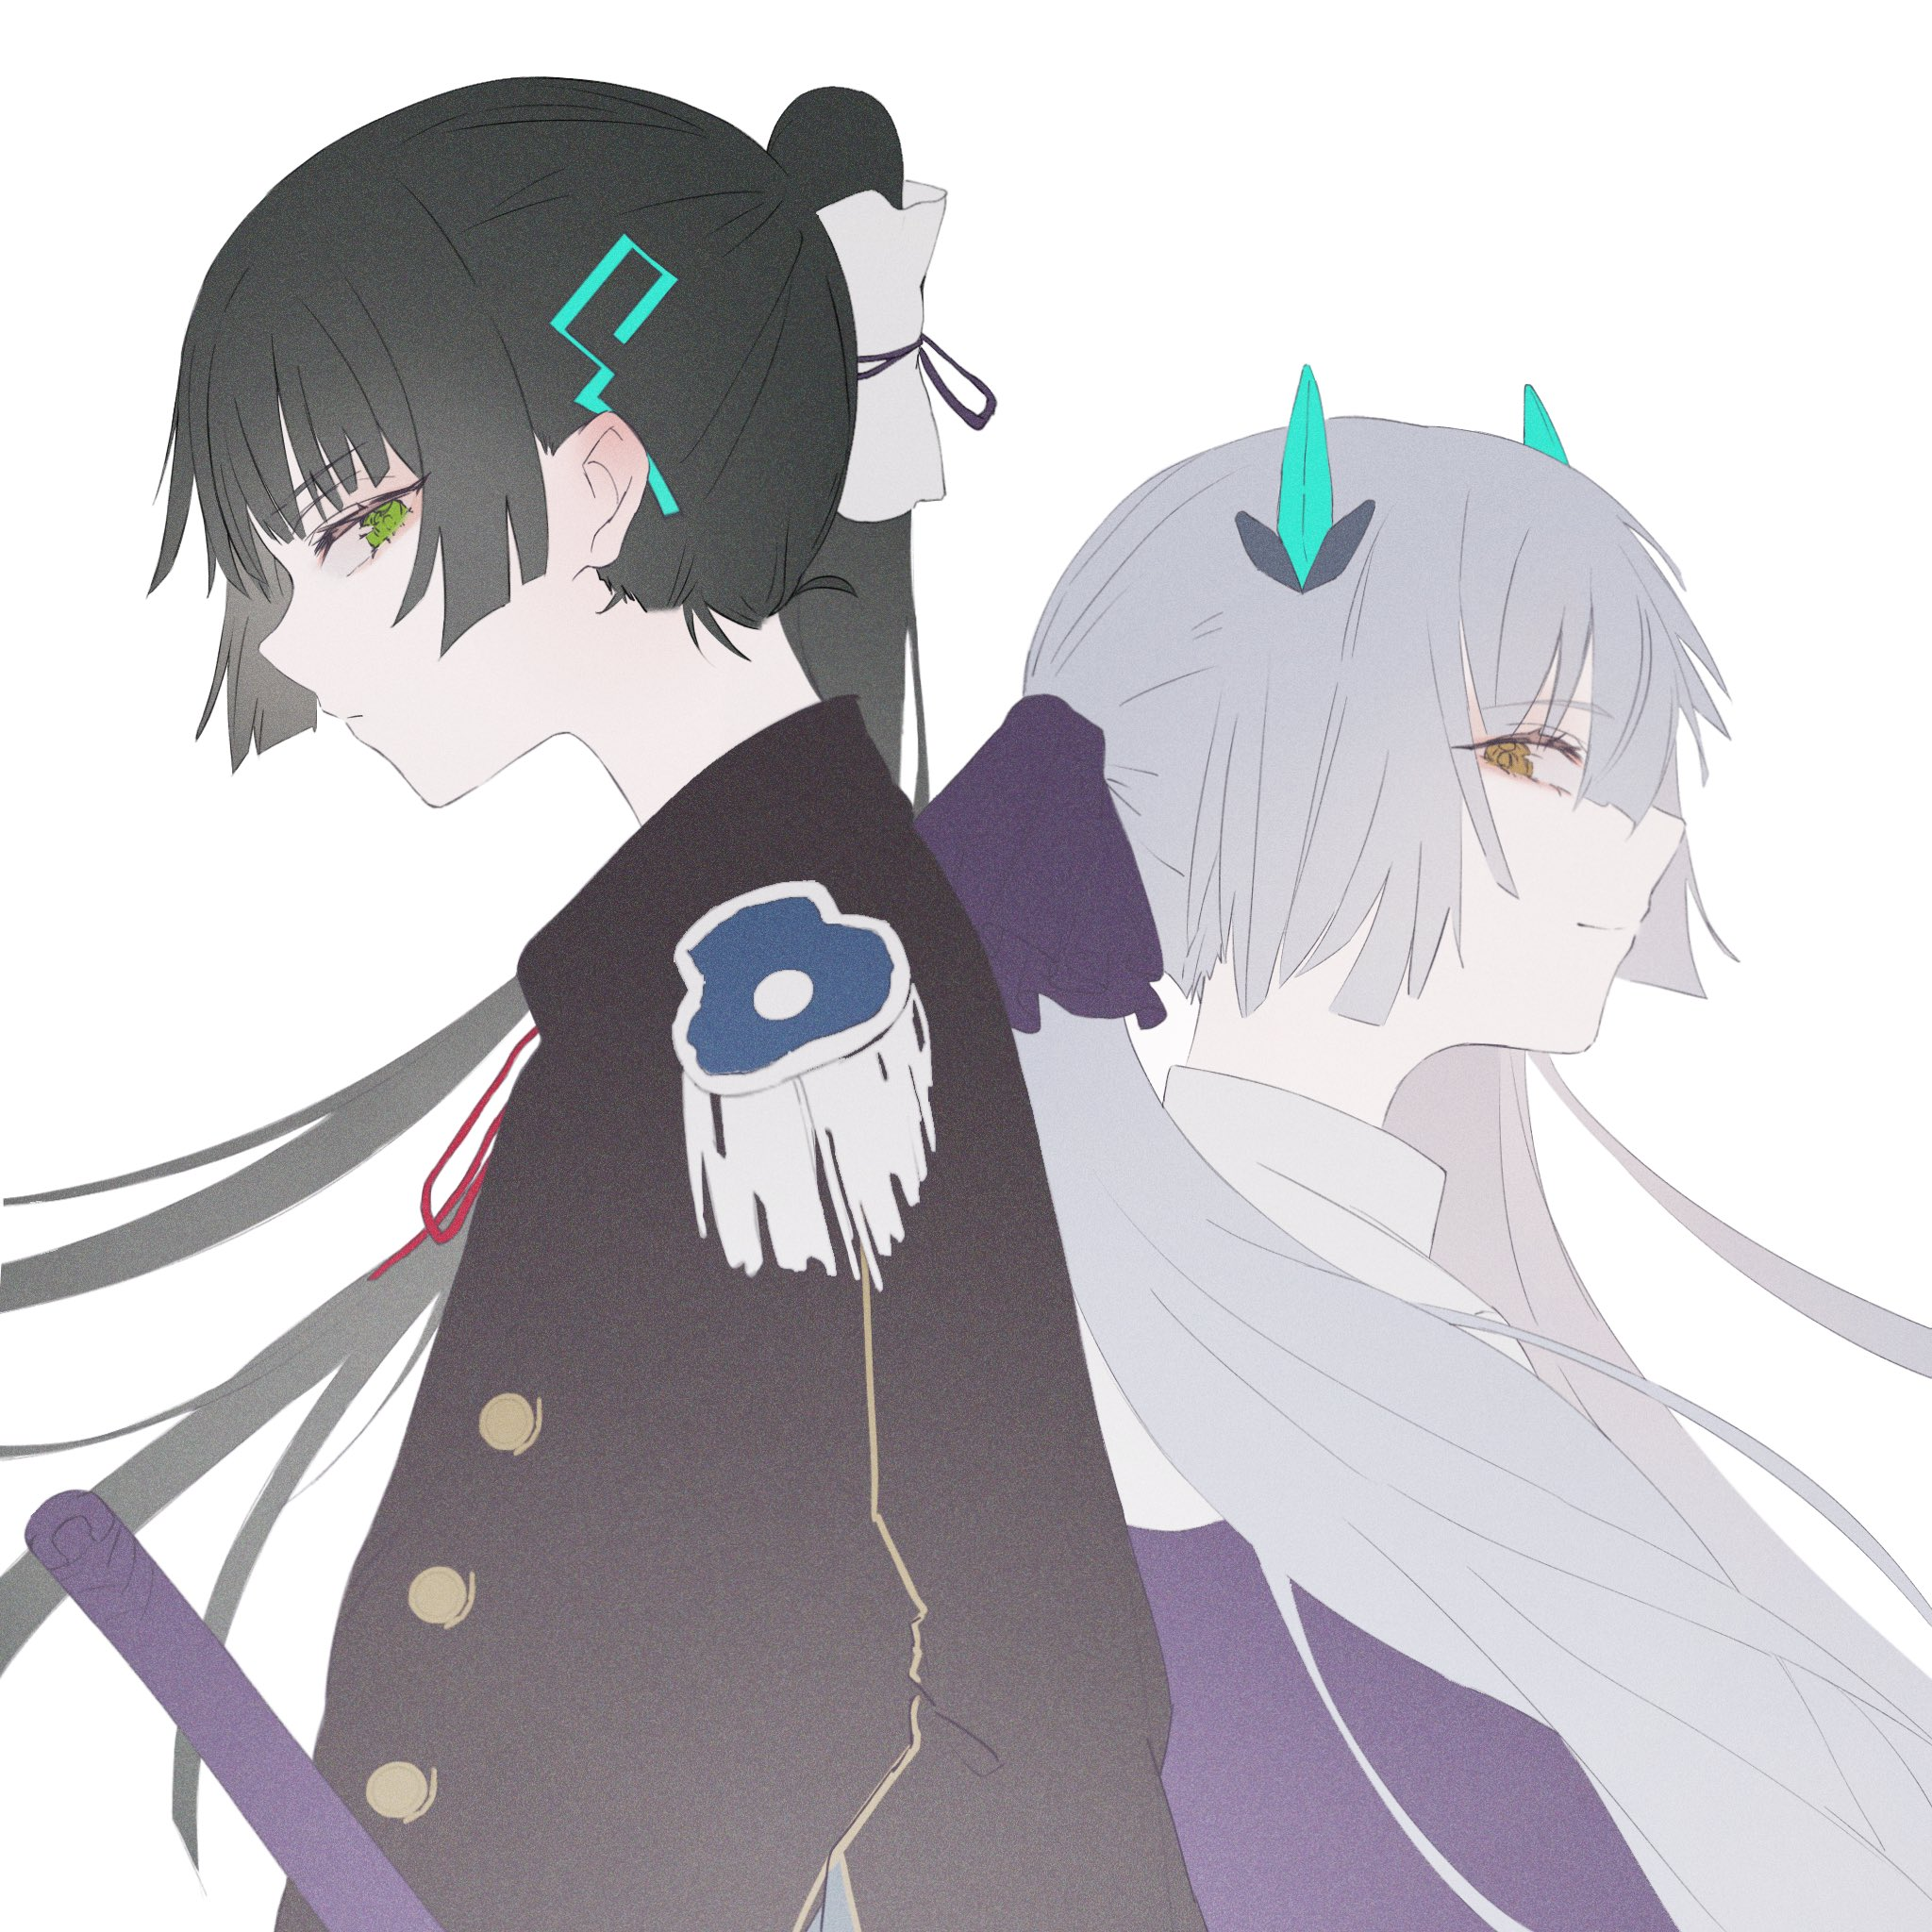

### 81336d40622651045ab2a9dfb6a51d41

- image: `/content/tagutl_nanami_v3/images/81336d40622651045ab2a9dfb6a51d41.jpg`

- caption: `wbon heaven_burns_red aoi_erika minase_ichigo 2girls black_hair blonde_hair blue_bow blue_bowtie blush bow bowtie closed_eyes coat fur-trimmed_coat fur_trim jacket jewelry kiss multiple_girls ring simple_background white_background yellow_j...`

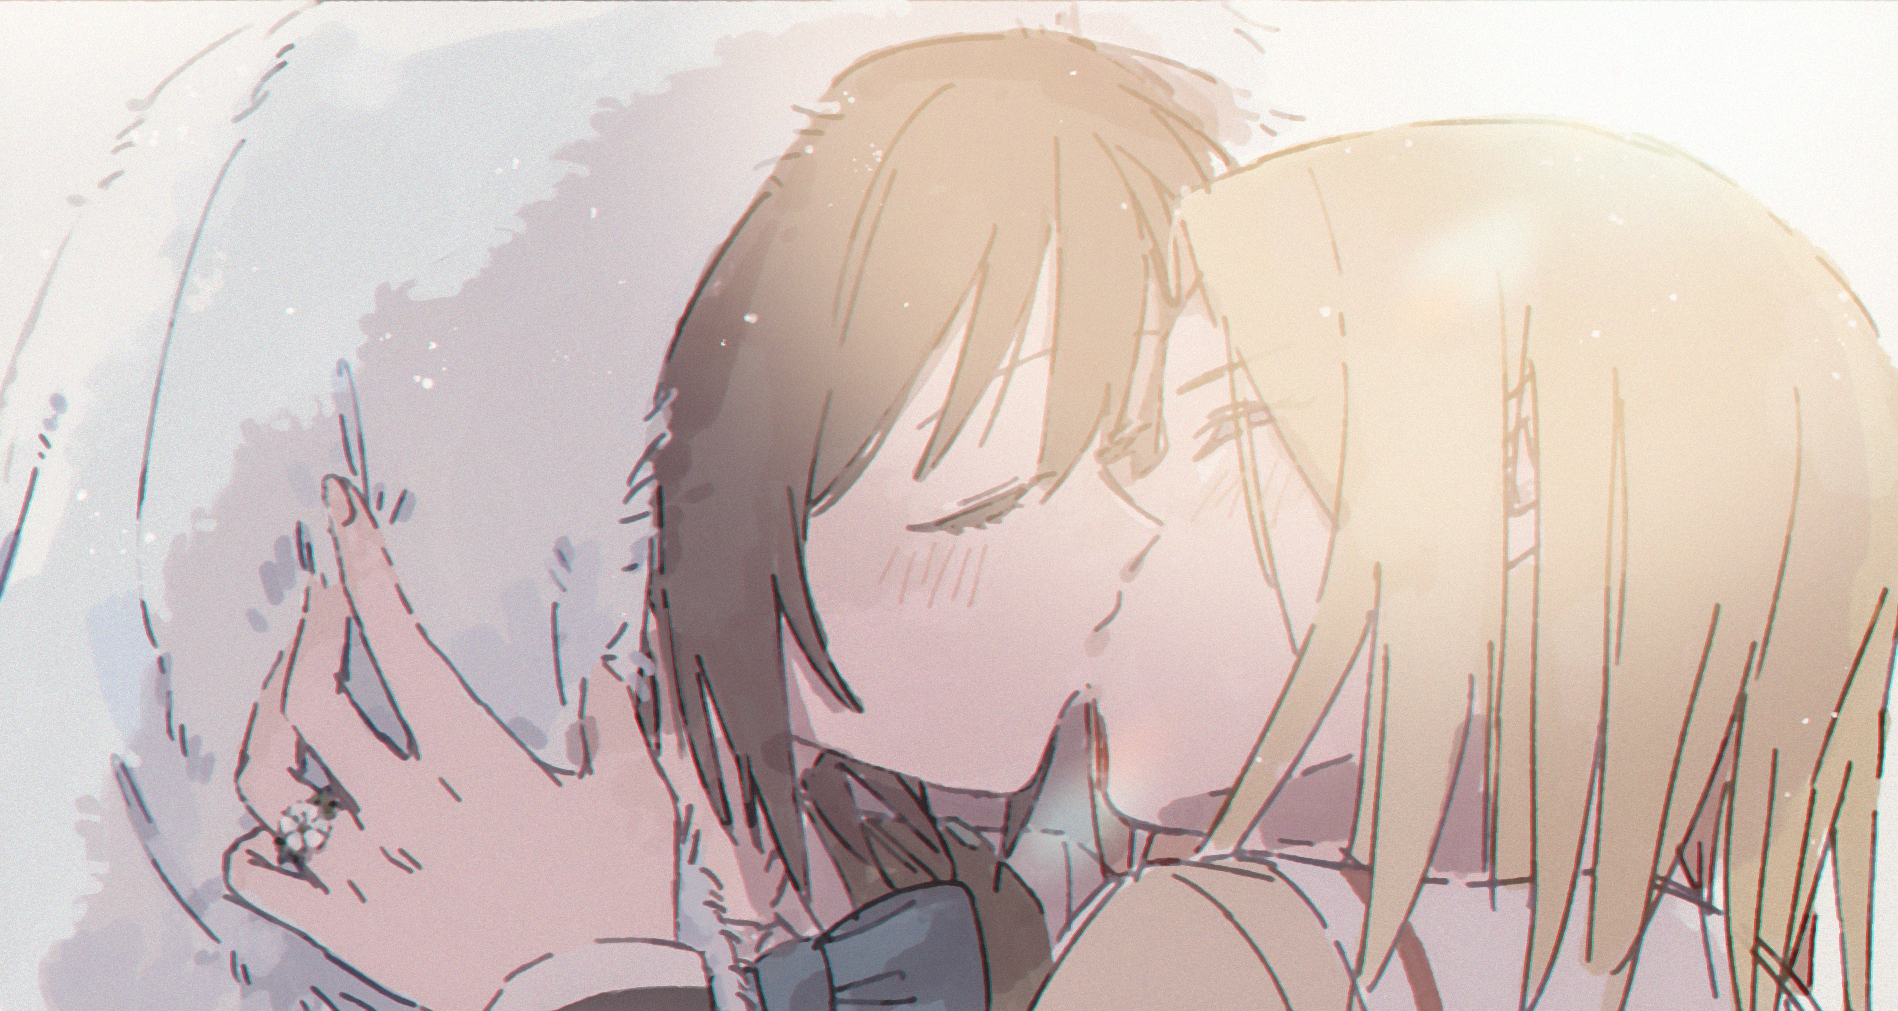

### 3c4ac88fbd01677040c389ee942fb61b

- image: `/content/tagutl_nanami_v3/images/3c4ac88fbd01677040c389ee942fb61b.jpg`

- caption: `oyama_sou heaven_burns_red shirakawa_yuina 1girl bikini blonde_hair blue_bikini breasts cleavage collarbone hand_fan large_breasts long_hair navel red_eyes see-through_clothes sidelocks solo swimsuit hashtag-only_commentary highres`

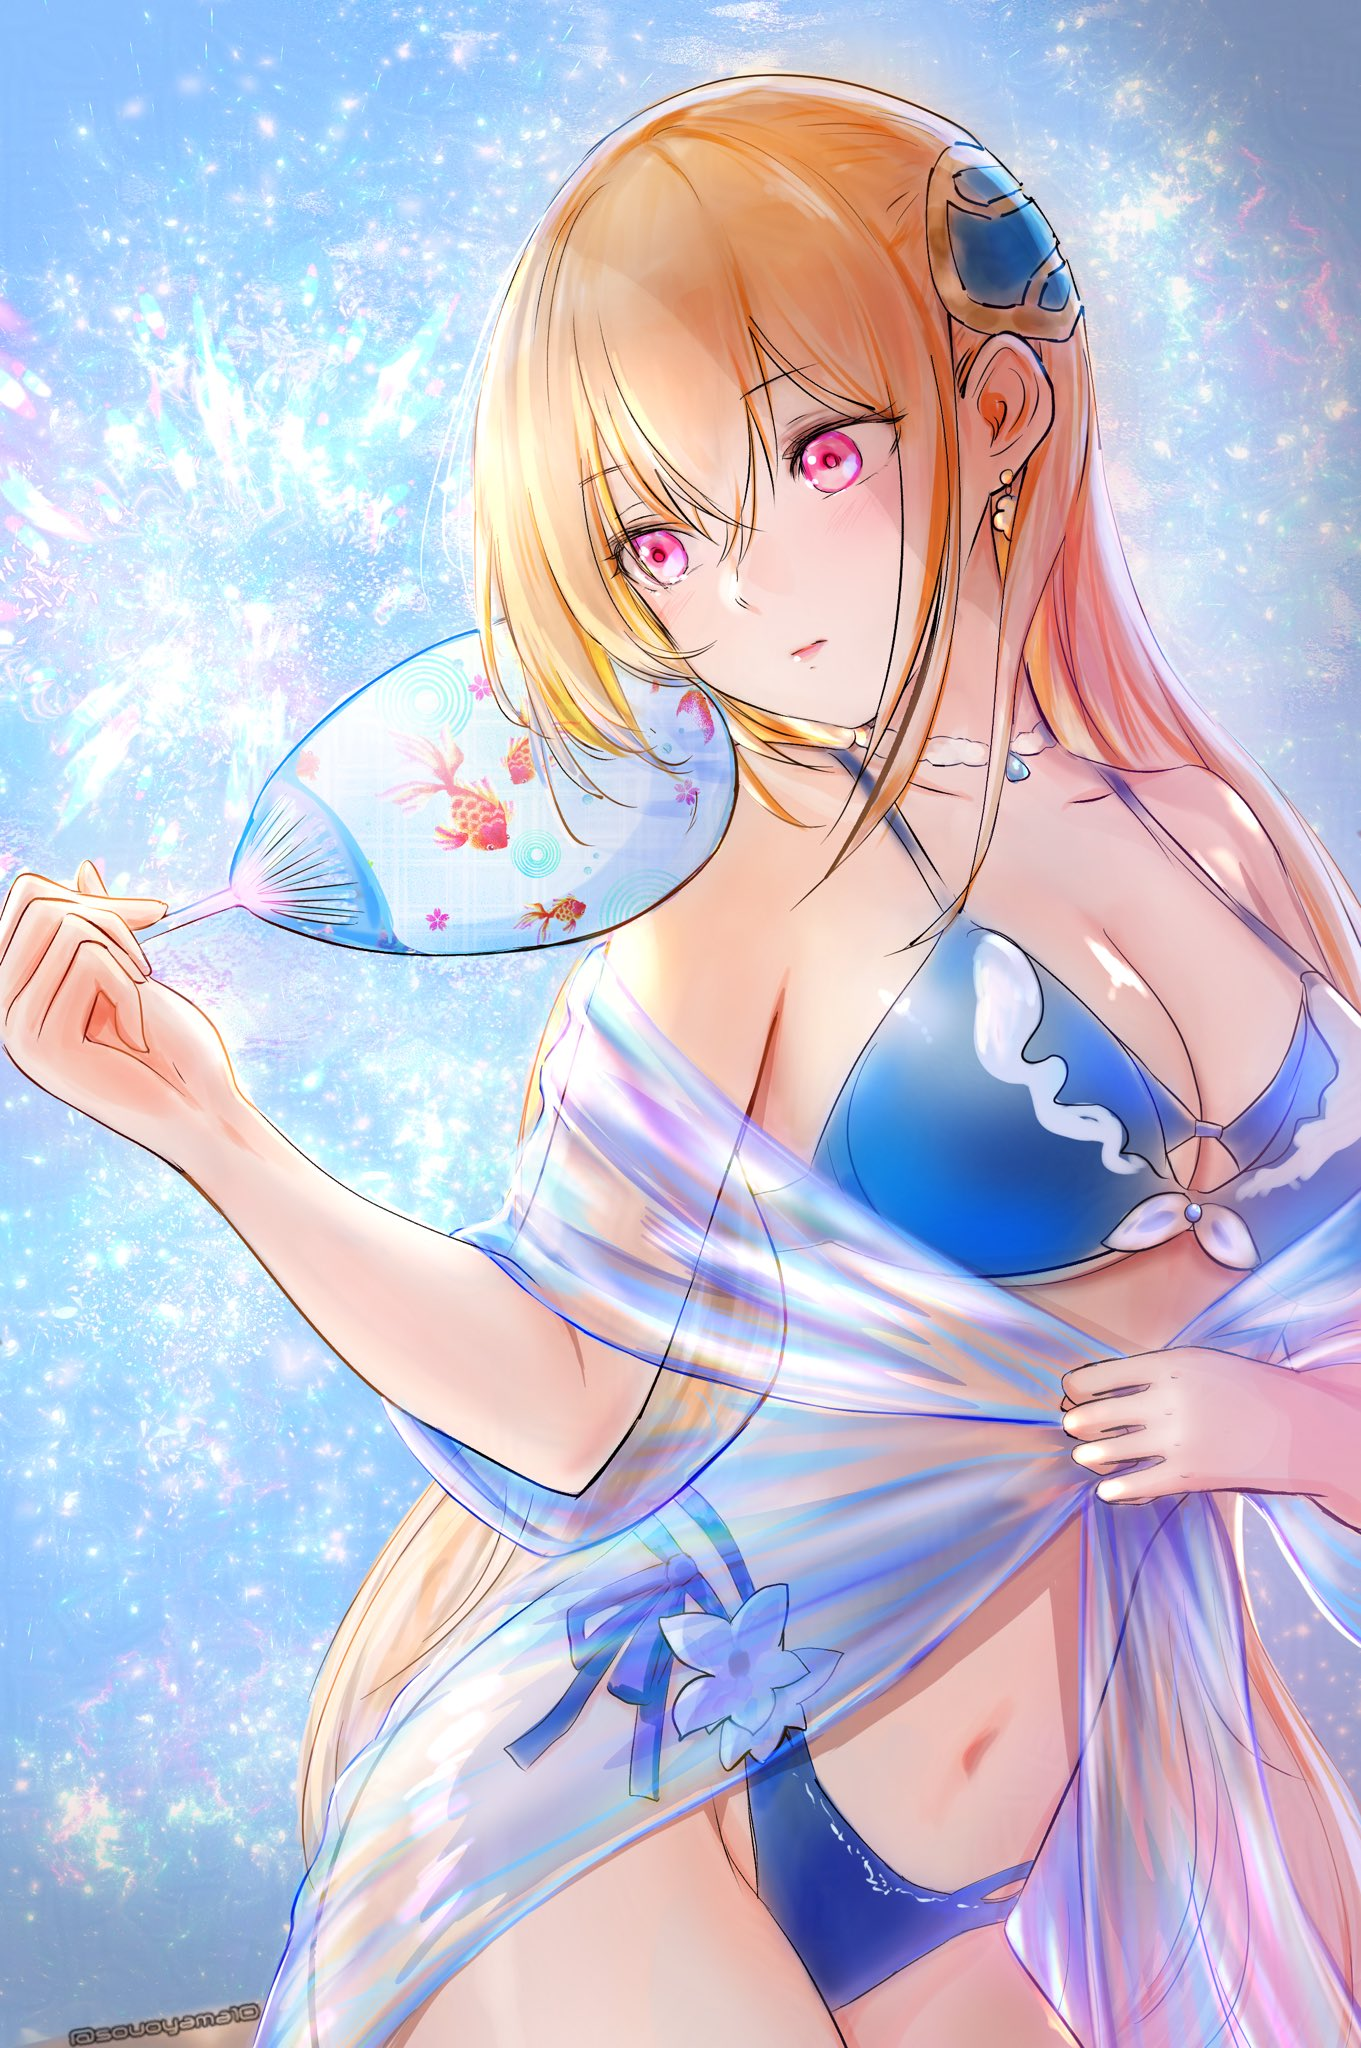

In [5]:
import glob, random, os
from IPython.display import display, Markdown, Image as IPyImage

imgs = glob.glob(os.path.join(OUT_DIR, "images", "*.*"))
samples = random.sample(imgs, k=min(3, len(imgs)))

for p in samples:
    md5 = os.path.splitext(os.path.basename(p))[0]
    cap = os.path.join(OUT_DIR, "captions", md5 + ".txt")
    cap_text = open(cap, encoding="utf-8").read().strip() if os.path.exists(cap) else "(missing)"
    display(Markdown(f"### {md5}"))
    display(Markdown(f"- image: `{p}`"))
    display(Markdown(f"- caption: `{cap_text[:240]}{'...' if len(cap_text)>240 else ''}`"))
    display(IPyImage(filename=p))


In [6]:
!pip -q install pillow

In [7]:
!unzip -o viewer_colab.zip -d /content/viewer
!ls /content/viewer

Archive:  viewer_colab.zip
  inflating: /content/viewer/app.js  
  inflating: /content/viewer/index.html  
  inflating: /content/viewer/server.py  
  inflating: /content/viewer/styles.css  
app.js	index.html  server.py  styles.css


In [12]:
import os, json

OUT_DIR = "/content/tagutl_nanami_v3"
src = os.path.join(OUT_DIR, "index.jsonl")
dst = os.path.join(OUT_DIR, "dataset_index_fixed.jsonl")

n = 0
with open(src, "r", encoding="utf-8") as f_in, open(dst, "w", encoding="utf-8") as f_out:
    for line in f_in:
        line = line.strip()
        if not line:
            continue
        r = json.loads(line)

        out = {
            # viewer가 실제 파일을 찾을 때 쓰는 값
            "image_path": r["image_path"],

            # viewer가 태그 표시할 때 쓰는 값 (키 이름만 맞춰주면 됨)
            "artist": r.get("tag_artist", []),
            "copyright": r.get("tag_copyright", []),
            "character": r.get("tag_character", []),
            "general": r.get("tag_general", []),

            # 유지하고 싶으면 추가 필드로 남겨도 됨(기본 viewer는 무시)
            "meta": r.get("tag_meta", []),

            # 디버깅/추적용(있어도 viewer는 무시)
            "md5": r.get("md5"),
            "post_id": r.get("post_id"),
            "created_at": r.get("created_at"),
            "updated_at": r.get("updated_at"),
            "rating": r.get("rating"),
            "file_ext": r.get("file_ext"),
            "caption_path": r.get("caption_path"),
        }

        f_out.write(json.dumps(out, ensure_ascii=False) + "\n")
        n += 1

print("saved:", dst)
print("rows:", n)


saved: /content/tagutl_nanami_v3/dataset_index_fixed.jsonl
rows: 2739


In [13]:
import os, subprocess, socket, time

PORT = 8188
ROOT = OUT_DIR
VIEWER_LOG = "/content/viewer.log"

# 기존 서버 있으면 종료
subprocess.run(["pkill", "-f", "/content/viewer/server.py"], check=False)

log_f = open(VIEWER_LOG, "w")

viewer_proc = subprocess.Popen(
    [
        "python", "/content/viewer/server.py",
        "--root", ROOT,
        "--port", str(PORT),

        # (선택) 썸네일/디스플레이 생성 부담 줄이기
        "--thumb-size", "256",
        "--thumb-quality", "75",
        "--display-size", "1200",
        "--display-quality", "82",
    ],
    stdout=log_f,
    stderr=subprocess.STDOUT,
)

def wait_port(port, timeout=30):
    t0 = time.time()
    while time.time() - t0 < timeout:
        time.sleep(0.3)
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as sock:
            if sock.connect_ex(("127.0.0.1", port)) == 0:
                return True
    return False

ok = wait_port(PORT)
print("✅ Viewer ready" if ok else "❌ Viewer did not open port")
print(f"local: http://127.0.0.1:{PORT}")
print(f"log:  {VIEWER_LOG}")


✅ Viewer ready
local: http://127.0.0.1:8188
log:  /content/viewer.log


In [14]:
%%bash
if ! command -v cloudflared >/dev/null 2>&1; then
  wget -q -O /tmp/cloudflared.deb https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
  dpkg -i /tmp/cloudflared.deb >/dev/null 2>&1 || apt-get -y -f install >/dev/null 2>&1
fi

cloudflared --version
which cloudflared

cloudflared version 2025.11.1 (built 2025-11-07-16:59 UTC)
/usr/local/bin/cloudflared


In [15]:
import subprocess, time, re

TUN_LOG = "/content/cloudflared.log"

# 기존 터널 있으면 종료
subprocess.run(["pkill", "-f", "cloudflared tunnel"], check=False)

tun_f = open(TUN_LOG, "w")

tun_proc = subprocess.Popen(
    ["cloudflared", "tunnel", "--protocol", "http2", "--url", "http://127.0.0.1:8188"],
    stdout=tun_f,
    stderr=subprocess.STDOUT,
)

time.sleep(3)
print("✅ Cloudflared started")
print("log:", TUN_LOG)

# 터널 URL 한 번 뽑아보기(로그에서 trycloudflare 주소 찾기)
try:
    with open(TUN_LOG, "r", encoding="utf-8", errors="ignore") as f:
        txt = f.read()
    m = re.search(r"https://[a-z0-9-]+\.trycloudflare\.com", txt)
    if m:
        print("✅ Tunnel URL:", m.group(0))
    else:
        print("⚠️ Tunnel URL not found yet. Check logs.")
except Exception as e:
    print("log read failed:", e)


✅ Cloudflared started
log: /content/cloudflared.log
⚠️ Tunnel URL not found yet. Check logs.


In [16]:
import time, re

TUN_LOG = "/content/cloudflared.log"

url = None
for _ in range(30):  # 최대 ~15초
    time.sleep(0.5)
    try:
        with open(TUN_LOG, "r", encoding="utf-8", errors="ignore") as f:
            txt = f.read()
        m = re.search(r"https://[a-z0-9-]+\.trycloudflare\.com", txt)
        if m:
            url = m.group(0)
            break
    except Exception:
        pass

if url:
    print("✅ Tunnel URL:", url)
else:
    print("❌ Still no URL. Showing last 80 log lines:")
    print("-" * 60)
    !tail -n 80 /content/cloudflared.log


✅ Tunnel URL: https://camp-mental-crawford-differ.trycloudflare.com


In [22]:
!tail -n 60 /content/viewer.log
!tail -n 120 /content/cloudflared.log

2026-01-17T14:00:18Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2026-01-17T14:00:18Z INF Requesting new quick Tunnel on trycloudflare.com...
2026-01-17T14:00:22Z INF +--------------------------------------------------------------------------------------------+
2026-01-17T14:00:22Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):  |
2026-01-17T14:00:22Z INF |  https://clan-internet-anderson-maintaining.trycloudfl

In [23]:
try:
    viewer_proc.terminate()
    viewer_proc.wait(timeout=3)
except Exception:
    pass

# Danbooru → Hugging Face Dataset 운영 메모 (재개/중복/메타갱신 포함)

이 저장소(들)는 Danbooru에서 이미지와 메타데이터를 수집해 Hugging Face Datasets(Hub)에 올리고,
런타임 중단/재실행에도 **중복 다운로드 없이 이어받고**, 태그 변경 같은 **메타 갱신도 반영**하기 위한 운영 기록이다.

---

## 0) 핵심 요약 (한 줄씩)

- Danbooru의 기본 단위는 **post**(id)이고, 파일 단위 중복 제거는 **md5**가 가장 안정적이다.
- Danbooru는 태그/메타가 바뀌면 `updated_at`이 바뀌고 `order:updated` 정렬에서 글이 위로 튀어오른다.
- HF Datasets는 같은 split 내에서 **스키마(features)가 같아야** 하므로, 서로 다른 테이블(images/meta)은 **repo를 분리**하는 게 운영이 쉽다.
- 재개(resume)는 gallery-dl의 `--download-archive`(sqlite3)로 해결한다.
- 메타 갱신은 `order:updated` 상위 N페이지를 주기적으로 재스캔해서 snapshot을 누적하고, 학습 시 최신만 선택한다.

---

## 1) Danbooru 데이터 모델 정리

### 1.1 Post와 ID
- Danbooru에서 검색 결과의 한 항목은 **post**다.
- `post_id`(= `id`)는 한 번 생성되면 **변하지 않는 식별자**다.
- 다만 “검색 목록에서의 위치”는 정렬 기준에 따라 계속 바뀐다.
  - `order:id` : id 기준 정렬(안정적)
  - `order:updated` : 태그/메타가 업데이트되면 위로 이동(불안정)
  - `order:score` 등 : 점수 변화에 따라 이동

### 1.2 md5 (파일 단위 식별자)
- Danbooru JSON 메타에 `md5`가 존재하며, 이는 파일(바이너리) 단위의 사실상 고유키로 사용 가능하다.
- post가 그대로여도 파일이 교체되면 md5가 바뀔 수 있다.
- 따라서:
  - **파일 중복 제거/저장**은 md5 중심
  - **포스트/태그 변화 추적**은 post_id + updated_at 중심

### 1.3 태그 업데이트는 자주 일어난다
- 유저들이 태그/메타를 계속 수정한다.
- `updated_at`이 갱신되면 `order:updated`에서 오래된 글이 최신 목록으로 올라갈 수 있다.
- 승인(pending approval) 상태 변화도 검색 결과 포함 여부에 영향을 줄 수 있다.

---

## 2) Hugging Face Datasets 구조/제약

### 2.1 HF Dataset repo 내부 구조
- `push_to_hub()`를 하면 대체로 `data/train-00000-of-00001.parquet` 같은 parquet shard가 생성된다.
- HF는 split(`train`, `test`, `validation` 등)별로 **하나의 테이블 스키마(features)**를 가진다고 보면 된다.

### 2.2 중요한 제약: 같은 split에 서로 다른 스키마를 섞을 수 없다
- `DatasetDict`는 “서로 다른 스키마의 테이블 묶음”이 아니라 “split 묶음”이다.
- images 테이블과 meta 테이블은 컬럼이 다르므로, 같은 repo에 동시에 올리려 하면 스키마 불일치 오류가 날 수 있다.

**권장 구조**
- `*_images` repo: 이미지 테이블 1개 (train split)
- `*_meta` repo: 메타 테이블 1개 (train split)

---

## 3) 운영 설계 (이번 파이프라인 기준)

### 3.1 Repo 분리 설계

#### A) images repo (파일 단위)
- 기본키: `md5`
- 컬럼 예시:
  - `md5` (string)
  - `image` (datasets.Image)
  - `file_ext` (string)
  - `file_size` (int64)
  - `first_seen_post_id` (int64)
  - `first_seen_at` (string, ISO)
  - `source_file_url` (string)

#### B) meta repo (post 스냅샷)
- 스냅샷 키(논리적): `(post_id, updated_at)`
- 컬럼 예시:
  - `post_id` (int64)
  - `updated_at` (string)
  - `created_at` (string)
  - `md5` (string)
  - `rating`, `score`, `fav_count`, `parent_id`, `source`, `is_deleted`
  - `tag_artist`, `tag_copyright`, `tag_character`, `tag_general` (list[string])
  - `post_url`, `file_url`, `large_file_url`, `preview_file_url`

### 3.2 재개(resume) 설계: gallery-dl archive + HF state
- 로컬:
  - `archive.sqlite3` : gallery-dl `--download-archive`로 생성
- HF(images repo)에 저장:
  - `state/archive.sqlite3`
  - `state/state.json` (예: `{ "last_run_at": "..." }`)

재실행 시:
1) HF에서 `state/archive.sqlite3`를 내려받아 로컬 archive로 사용
2) gallery-dl이 archive를 참고해서 이미 받은 건 스킵
3) 끝나면 최신 archive/state를 HF로 다시 업로드

### 3.3 메타 갱신 전략: `order:updated` 재스캔
Danbooru에서 태그/메타 업데이트가 발생하면 `order:updated` 상단으로 튀어오르므로:

- 기본 수집: `tags=<캐릭터>`
- 업데이트 재스캔: `tags=<캐릭터> order:updated` 상위 N페이지

이때 meta는 `(post_id, updated_at)` 기준으로 누적 저장하고,
학습 단계에서 `post_id`별로 최신 `updated_at`만 택하면 된다.

---

## 4) 이번에 실제로 겪은 실패와 원인(재발 방지용)

### 4.1 Danbooru API 422(TagLimitError)
- API 방식으로 조합 검색을 시도하면 태그 제한 등으로 422가 날 수 있다.
- 초반에 잘 되던 방식(웹 URL + gallery-dl)이 안정적이므로, 기본 수집은 gallery-dl 유지가 안전하다.

### 4.2 HF에서 images/meta를 한 repo에 올리려다 스키마 충돌
- DatasetDict는 split 묶음이므로 서로 다른 테이블 스키마(images/meta)를 함께 넣으면 오류가 날 수 있다.
- 해결: images repo와 meta repo를 분리.

### 4.3 `_load_split()`이 실패해서 기존 md5를 못 읽고 전부 “신규”로 처리됨
- 증상:
  - `images_existing is None? True`
  - `md5_existing size: 0`
  - 매 실행마다 “신규 N장”이 전체처럼 잡힘
- 원인:
  - `load_dataset()` 호출에 불필요한 옵션(data_files/use_auth_token/download_mode 등)을 섞어서
    환경/버전 차로 실패 가능성이 커짐
- 해결:
  - **검증된 최소 호출만 사용**: `load_dataset(repo_id, split="train", token=hf_token)`

### 4.4 hub API 호출 방식(TypeError)
- `HfApi.upload_file()`는 버전별로 keyword-only 인자 요구 등 차이가 있어,
  positional 호출로 쉽게 깨진다.
- 해결:
  - dataset 업로드는 `push_to_hub()` 중심으로 통일
  - 상태 파일만 `upload_file(keyword-only)`로 업로드

---

## 5) 다음 실행 체크리스트 (이 순서대로 하면 안전)

1) **state 존재 확인**
   - HF(images repo)에서 `state/archive.sqlite3`, `state/state.json` 파일이 있는지 확인

2) **기존 dataset 로드 확인**
   - `load_dataset(images_repo, split="train", token=...)`가 성공하는지 확인
   - 실패하면 md5_existing이 비게 되므로, 그 run에서는 “중복 제외”가 깨진다(중단 권장)

3) **gallery-dl 실행**
   - 기본 수집 + `order:updated` 상위 N페이지 재스캔

4) **dedup 규칙**
   - images: md5 기준
   - meta: `(post_id, updated_at)` 기준

5) **업로드**
   - images repo(train), meta repo(train)
   - state/archive.sqlite3 + state/state.json 업로드

---

## 6) 학습에서 쓰는 방법(권장)

- meta repo에서 `post_id`별 최신 `updated_at`만 선택
- 그 최신 meta의 `md5`로 images repo와 조인
- caption은 `tag_*`를 원하는 규칙으로 조합해서 생성

> 저장 단계에서는 “최대한 원본에 가까운 누적/기록”을 유지하고,
> 학습 단계에서 필터링/최신선택/캡션정제 등을 수행하는 편이 운영이 안정적이다.

---
